In [1]:
import os
import math
import numpy as np

import torch
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm

from GeospatialFM.datasets.utils import get_ssl4eo_metadata
from GeospatialFM.data import apply_transforms, pretrain_transform, multimodal_collate_fn
from GeospatialFM.models import SpatialSpectralLowRankViTConfig, SpatialSpectralMAEViT
from GeospatialFM.models.low_rank_attention import get_perception_field_mask
from GeospatialFM.models import PositionalChannelEmbedding
from GeospatialFM.datasets import SSL4EODataset
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import rasterio
import pandas as pd
import json

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def norm_image(image):
    image = image - image.min()
    image = image / image.max()
    return image

## SSL4EO

In [3]:
metadata = get_ssl4eo_metadata()
optical_mean, optical_std = metadata["s2c"]["mean"], metadata["s2c"]["std"]
radar_mean, radar_std = metadata["s1"]["mean"], metadata["s1"]["std"]

In [4]:
dataset = dict(train=SSL4EODataset(root="/home/haozhesi/Dropbox/GeospatialFM/data/geospatial/SSL4EO"))
apply_transform = partial(apply_transforms, optical_mean=optical_mean, optical_std=optical_std, radar_mean=radar_mean, radar_std=radar_std, use_8bit=False)
collate_fn = partial(multimodal_collate_fn, transform=pretrain_transform, normalization=apply_transform)

In [5]:
batch_size = 4

train_loader = DataLoader(
    dataset['train'], 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4, 
    collate_fn=collate_fn
)

## Model

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define configuration
config = SpatialSpectralLowRankViTConfig(
    patch_size=16,
    embed_dim=768,
    channel_embed_dims_per_head=1,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=12,
    decoder_num_heads=16,
    decoder_channel_embed_dims_per_head=1,
    use_perception_field_mask=True,
    attention_radius=640,
    norm_pix_loss=False,
    decoder_out_chans = 15
)

# Initialize model
model = SpatialSpectralMAEViT(config)

## Training Code

In [7]:
# Set model to training mode
device = 'cuda:2'
model.to(device, dtype=torch.bfloat16)
model.train()
print()

In [8]:
# load checkpoint
model.load_state_dict(torch.load("/home/haozhesi/Dropbox/GeospatialFM/results/models/LRSSVIT-ViTDecoder-clstoken2/checkpoint-500/pytorch_model.bin", map_location=device))

<All keys matched successfully>

In [9]:
for batch in tqdm(train_loader):
    optical = batch['optical'].to(device, dtype=torch.bfloat16)
    radar = batch['radar'].to(device, dtype=torch.bfloat16)
    optical_channel_wv = batch['optical_channel_wv']
    radar_channel_wv = batch['radar_channel_wv']
    spatial_resolution = batch['spatial_resolution']
    # Run forward pass
    output = model(
        optical=optical,
        radar=radar,
        optical_channel_wv=optical_channel_wv,
        radar_channel_wv=radar_channel_wv,
        mask_ratio=0.75,
        channel_mask_ratio=0.5,
        spatial_resolution=spatial_resolution,
        # modal='multi'
    )
    break

  0%|          | 0/62770 [00:00<?, ?it/s]

  0%|          | 0/62770 [00:01<?, ?it/s]


In [10]:
# model.eval()
# for batch in tqdm(train_loader):
#     optical = batch['optical'].to(device, dtype=torch.bfloat16)
#     radar = batch['radar'].to(device, dtype=torch.bfloat16)
#     optical_channel_wv = batch['optical_channel_wv']
#     radar_channel_wv = batch['radar_channel_wv']
#     spatial_resolution = batch['spatial_resolution']
#     encoder_output = model.encoder(optical=optical, radar=radar, optical_channel_wv=optical_channel_wv, radar_channel_wv=radar_channel_wv, 
#                                                                        spatial_resolution=spatial_resolution, mask_ratio=0, channel_mask_ratio=0)
#     break


In [11]:
# encoder_output[0][0, 0, 1:, :].shape

In [12]:
# plt.imshow((encoder_output[0][2, 0, 1:, 0]).to(torch.float32).detach().cpu().numpy().reshape(8, 8))

In [13]:
output["optical_recon"].shape

torch.Size([4, 15, 196, 256])

In [14]:
def cal_pos_loss(recon, target, pos_mask, channel_mask):
    pos_loss = torch.mean((recon - target).abs(), dim=[3]) # B, C, HW
    if channel_mask.sum() > 0:
        pos_loss = (pos_loss * (1 - channel_mask).unsqueeze(-1)).sum(dim=1) / (1 - channel_mask).sum(dim=1, keepdim=True) # B, HW
    else:
        pos_loss = pos_loss.mean(dim=1)  # Average over channels if no channel masking

    if pos_mask.sum() == 0:
        pos_loss = pos_loss.mean()
    else:
        pos_loss = (pos_loss * pos_mask).sum() / pos_mask.sum()
    return pos_loss

In [15]:
optical_pos_loss = cal_pos_loss(output['optical_recon'], output['target'], output['optical_pos_mask'], output['optical_channel_mask'])
radar_pos_loss = cal_pos_loss(output['radar_recon'], output['target'], output['radar_pos_mask'], output['radar_channel_mask'])
multi_pos_loss = cal_pos_loss(output['multi_recon'], output['target'], output['multi_pos_mask'], output['multi_channel_mask'])
optical_pos_loss, radar_pos_loss, multi_pos_loss

(tensor(0.0674, device='cuda:2', grad_fn=<DivBackward0>),
 tensor(0.1098, device='cuda:2', grad_fn=<DivBackward0>),
 tensor(0.0731, device='cuda:2', grad_fn=<DivBackward0>))

In [16]:
optical_pos_loss = (torch.mean((output['target'] - output['optical_recon']).abs(), dim=[1, 3]) * output['optical_pos_mask']).sum() / output['optical_pos_mask'].sum()
radar_pos_loss = (torch.mean((output['target'] - output['radar_recon']).abs(), dim=[1, 3]) * output['radar_pos_mask']).sum() / output['radar_pos_mask'].sum()
multi_pos_loss = (torch.mean((output['target'] - output['multi_recon']).abs(), dim=[1, 3]) * output['multi_pos_mask']).sum() / output['multi_pos_mask'].sum()
optical_pos_loss, radar_pos_loss, multi_pos_loss

(tensor(0.0825, device='cuda:2', grad_fn=<DivBackward0>),
 tensor(0.1032, device='cuda:2', grad_fn=<DivBackward0>),
 tensor(0.0810, device='cuda:2', grad_fn=<DivBackward0>))

In [17]:
optical_channel_loss = (torch.mean((output['target'] - output['optical_recon']).abs(), dim=[2, 3]) * output['optical_channel_mask']).sum() / output['optical_channel_mask'].sum()
radar_channel_loss = (torch.mean((output['target'] - output['radar_recon']).abs(), dim=[2, 3]) * output['radar_channel_mask']).sum() / output['radar_channel_mask'].sum()
multi_channel_loss = (torch.mean((output['target'] - output['multi_recon']).abs(), dim=[2, 3]) * output['multi_channel_mask']).sum() / output['multi_channel_mask'].sum()
optical_channel_loss, radar_channel_loss, multi_channel_loss

(tensor(0.0937, device='cuda:2', grad_fn=<DivBackward0>),
 tensor(0.1020, device='cuda:2', grad_fn=<DivBackward0>),
 tensor(0.0881, device='cuda:2', grad_fn=<DivBackward0>))

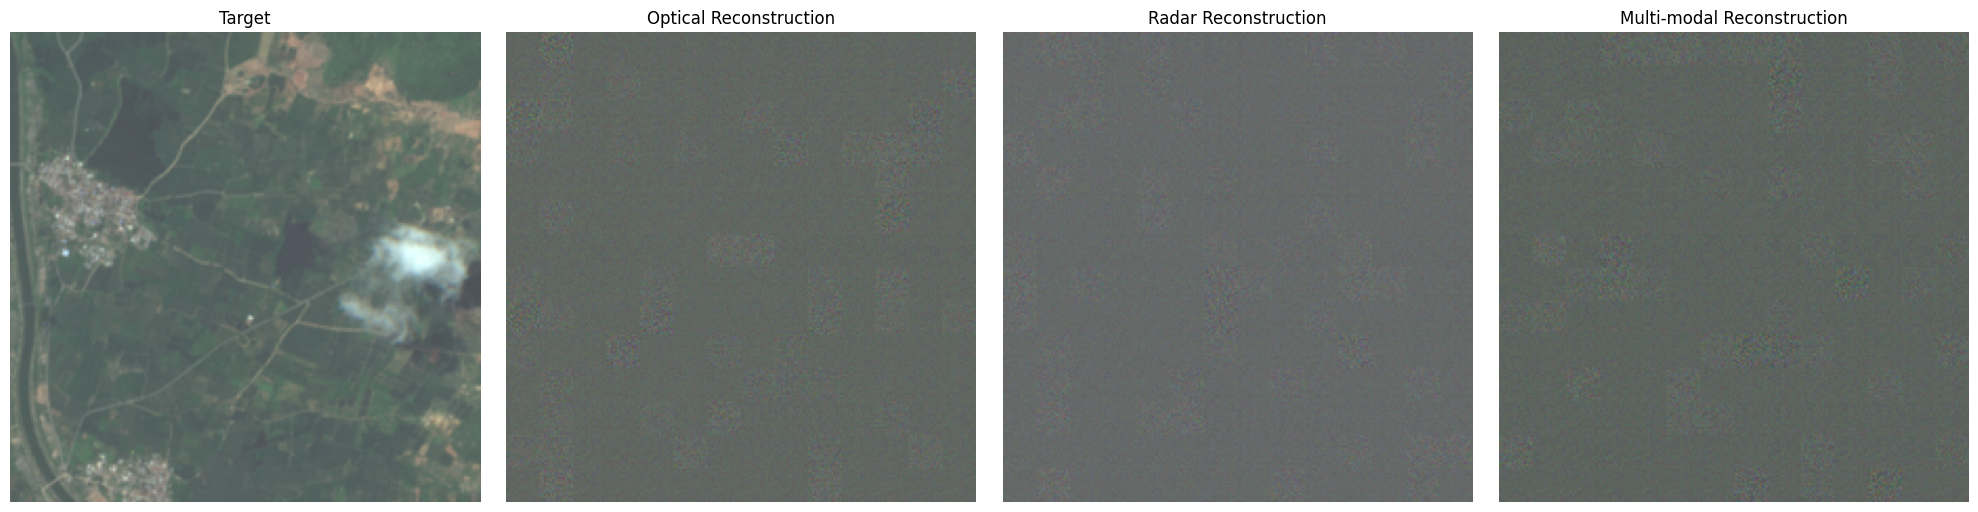

In [18]:
vis_idx = 1
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# all images are in RGB format
target_img = model.decoder.unpatchify(output['target'])[vis_idx].detach().cpu().to(torch.float32).numpy()[[3,2,1]].transpose(1,2,0)
optical_img = model.decoder.unpatchify(output['optical_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()[[3,2,1]].transpose(1,2,0)
radar_img = model.decoder.unpatchify(output['radar_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()[[3,2,1]].transpose(1,2,0)
multi_img = model.decoder.unpatchify(output['multi_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()[[3,2,1]].transpose(1,2,0)

# # normalize the images to be in [0, 1]
# target_img = norm_image(target_img)
# optical_img = norm_image(optical_img)
# radar_img = norm_image(radar_img)
# multi_img = norm_image(multi_img)

axs[0].imshow(target_img)
axs[0].set_title('Target')
axs[0].axis('off')

axs[1].imshow(optical_img)
axs[1].set_title('Optical Reconstruction')
axs[1].axis('off')

axs[2].imshow(radar_img)
axs[2].set_title('Radar Reconstruction')
axs[2].axis('off')

axs[3].imshow(multi_img)
axs[3].set_title('Multi-modal Reconstruction')
axs[3].axis('off')

plt.tight_layout()
plt.show()

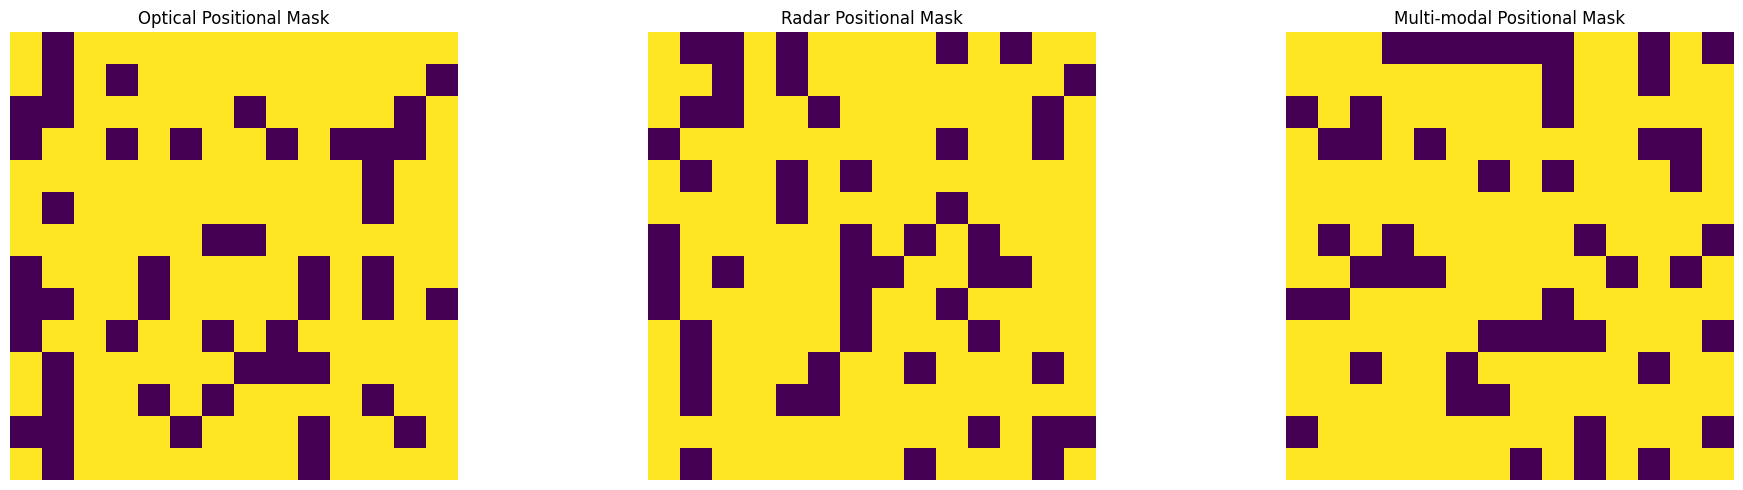

In [20]:
# visualize the spatial masks
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

n_patches = int(math.sqrt(output['optical_pos_mask'].shape[1]))

axs[0].imshow(output['optical_pos_mask'][vis_idx].detach().cpu().to(torch.float32).numpy().reshape(n_patches, n_patches))
axs[0].set_title('Optical Positional Mask')
axs[0].axis('off')

axs[1].imshow(output['radar_pos_mask'][vis_idx].detach().cpu().to(torch.float32).numpy().reshape(n_patches, n_patches))
axs[1].set_title('Radar Positional Mask')
axs[1].axis('off')

axs[2].imshow(output['multi_pos_mask'][vis_idx].detach().cpu().to(torch.float32).numpy().reshape(n_patches, n_patches))
axs[2].set_title('Multi-modal Positional Mask')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [21]:
output['multi_channel_mask'][0]

tensor([0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.],
       device='cuda:2')

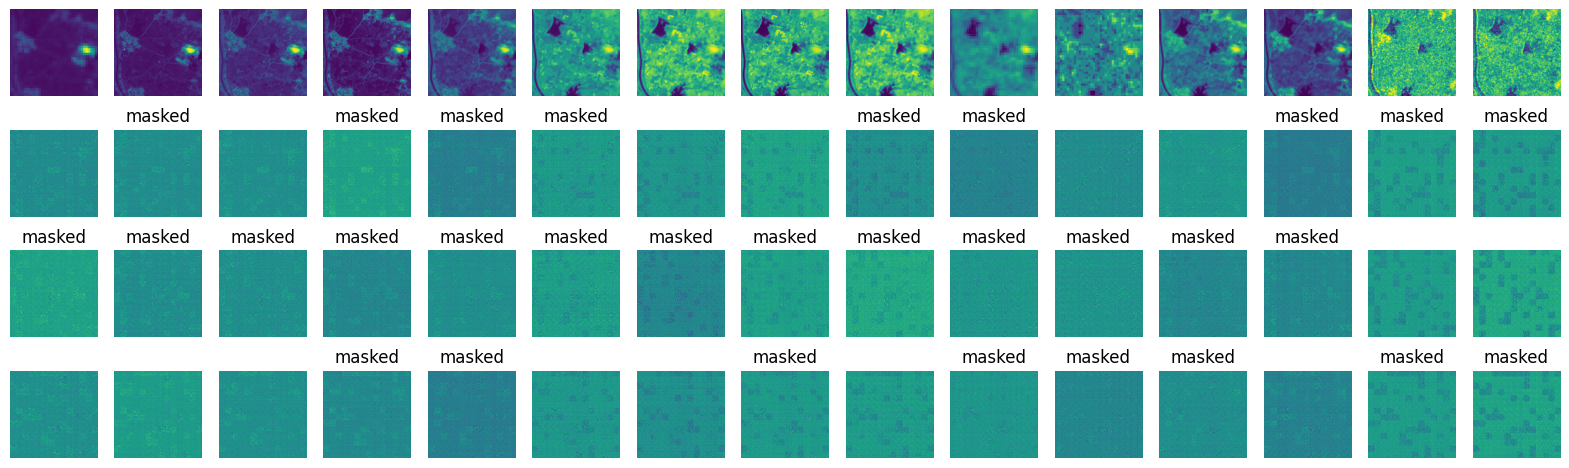

In [22]:
# visualize the reconstruction of every channel of every modality
# vis_idx = 0
fig, axs = plt.subplots(4, 15, figsize=(20, 6))
target_img = model.decoder.unpatchify(output['target'])[vis_idx].detach().cpu().to(torch.float32).numpy()
for i in range(15):
    axs[0, i].imshow(target_img[i])
    axs[0, i].axis('off')
for j, modal in enumerate(['optical', 'radar', 'multi']):
    spatial_mask = output[f'{modal}_pos_mask']
    masked_patches = output[f'{modal}_recon'] * spatial_mask.unsqueeze(1).unsqueeze(-1).expand_as(output[f'{modal}_recon'])
    unmasked_patches = output['target'] * (1-spatial_mask).unsqueeze(1).unsqueeze(-1).expand_as(output['target'])
    
    masked_channel_img = model.decoder.unpatchify(output[f'{modal}_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()
    masked_img = model.decoder.unpatchify(masked_patches)[vis_idx].detach().cpu().to(torch.float32).numpy()
    unmasked_img = model.decoder.unpatchify(unmasked_patches)[vis_idx].detach().cpu().to(torch.float32).numpy()
    masked_pos_img = unmasked_img + masked_img
    
    channel_mask = output[f'{modal}_channel_mask'][vis_idx].detach().cpu().to(torch.bool).numpy()
    for i in range(15):
        if channel_mask[i]:
            axs[j+1, i].imshow(masked_channel_img[i])
            axs[j+1, i].axis('off')
            axs[j+1, i].set_title('masked')
        else:
            # axs[j+1, i].imshow(masked_pos_img[i])
            axs[j+1, i].imshow(masked_channel_img[i])
            axs[j+1, i].axis('off')
plt.show()

In [55]:
decoder_embed_dim = 512
torch.nn.Conv1d(decoder_embed_dim, 256, kernel_size=1, groups=decoder_embed_dim).weight.data.shape

ValueError: out_channels must be divisible by groups

In [ ]:
torch.mean((target - optical_recon) ** 2, dim=[1, 3]).shape

In [ ]:
optical_pos_mask = output['optical_pos_mask']
optical_channel_mask = output['optical_channel_mask']
optical_pos_mask.shape, optical_pos_mask.sum(), optical_channel_mask.shape, optical_channel_mask.sum()

In [ ]:
(recon - target) ** 2 * pos_mask.unsqueeze(1).unsqueeze(-1).expand_as(recon)

In [ ]:
torch.mean((target - optical_recon) ** 2, dim=[2, 3]).shape